## 1. Importing tools

Firstly, lets import all tools we need.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from lightgbm import LGBMClassifier
from optuna.samplers import TPESampler
import optuna.integration.lightgbm as lightgbm
from sklearn.metrics import roc_auc_score
import optuna
from sklearn.feature_selection import RFECV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## 2. Exploratory data analysis

Before select the models, create some new features or chose them from existing, we need to analysis the data we got. Lets make it consistently.

## 2.1 Data reading and primary processing

In the follow cells we read the data and subsets them on targets table, which self-explanatory, and on another data, with whom we would treaking.

Also, before subset we drop all unknown target values and factorize it on 0 if tomorrow none rainy day and 1 otherwise.

In [ ]:
data = pd.read_csv('weatherAUS.csv')
data.dropna(subset=['RainTomorrow'], inplace=True)
data['RainTomorrow'] = pd.factorize(data['RainTomorrow'])[0]
target = data['RainTomorrow']
data = data.drop(['RainTomorrow'], axis=1)

Lets create two list with categorical and not features.

***object* - means non digital format**

***float64* - digital**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [ ]:
cat = ['Location',
       'WindGustDir',
       'WindDir9am',
       'WindDir3pm',
       'RainToday',
       'Date']
dig = [i for i in list(data) if i not in cat]

Further, we will work with *Nan* values.

In [ ]:
percent_nan = data.isna().sum()/data.shape[0]
percent_nan

Date             0.000000
Location         0.000000
MinTemp          0.004480
MaxTemp          0.002265
Rainfall         0.009888
Evaporation      0.427890
Sunshine         0.476929
WindGustDir      0.065615
WindGustSpeed    0.065193
WindDir9am       0.070418
WindDir3pm       0.026570
WindSpeed9am     0.009480
WindSpeed3pm     0.018496
Humidity9am      0.012476
Humidity3pm      0.025388
Pressure9am      0.098556
Pressure3pm      0.098324
Cloud9am         0.377353
Cloud3pm         0.401525
Temp9am          0.006358
Temp3pm          0.019171
RainToday        0.009888
dtype: float64

We will change the not a number value in digit columns for their mean, cat - nearest value in the same column.

In [ ]:
for ind, d in zip(percent_nan.index, percent_nan):
  if ind in dig and d != 0:
    data[ind].fillna(data[ind].mean(), inplace=True)

data.fillna(method='ffill', inplace=True)

Our next step is factorize the cat. features list to digit format.

In [ ]:
for c in cat:
  data['{}_dig'.format(c)] = pd.factorize(data[c])[0]

In [ ]:
cat_dig = ['{}_dig'.format(c) for c in cat]
features = dig + cat_dig

## 2.2 Data visualization

To find out insights in our data, lets visualize them.

array([[<AxesSubplot:title={'center':'MinTemp'}>,
        <AxesSubplot:title={'center':'MaxTemp'}>,
        <AxesSubplot:title={'center':'Rainfall'}>,
        <AxesSubplot:title={'center':'Evaporation'}>,
        <AxesSubplot:title={'center':'Sunshine'}>],
       [<AxesSubplot:title={'center':'WindGustSpeed'}>,
        <AxesSubplot:title={'center':'WindSpeed9am'}>,
        <AxesSubplot:title={'center':'WindSpeed3pm'}>,
        <AxesSubplot:title={'center':'Humidity9am'}>,
        <AxesSubplot:title={'center':'Humidity3pm'}>],
       [<AxesSubplot:title={'center':'Pressure9am'}>,
        <AxesSubplot:title={'center':'Pressure3pm'}>,
        <AxesSubplot:title={'center':'Cloud9am'}>,
        <AxesSubplot:title={'center':'Cloud3pm'}>,
        <AxesSubplot:title={'center':'Temp9am'}>],
       [<AxesSubplot:title={'center':'Temp3pm'}>,
        <AxesSubplot:title={'center':'Location_dig'}>,
        <AxesSubplot:title={'center':'WindGustDir_dig'}>,
        <AxesSubplot:title={'center':'WindDi

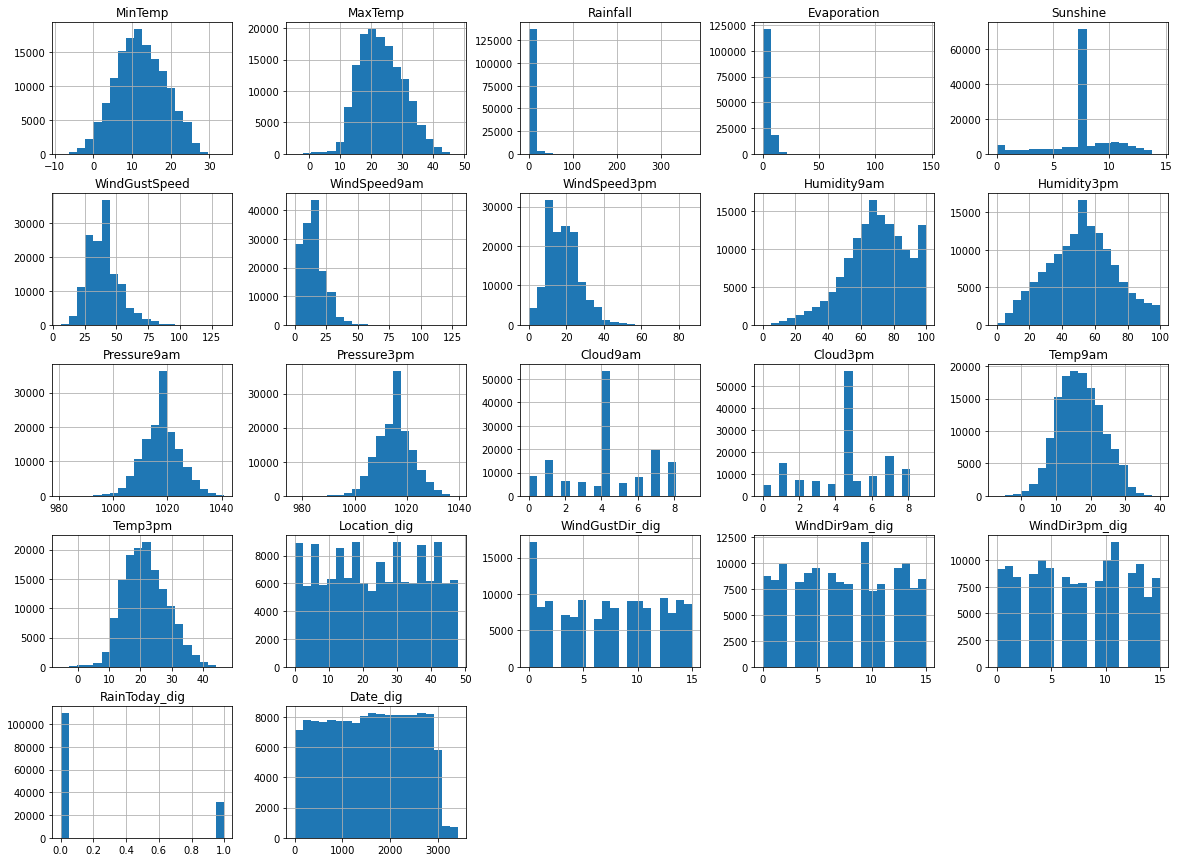

In [ ]:
data[features].hist(figsize=(20, 15), bins=20)

As we can see, categorical columns mostly had uniform distribution.

Digital columns had nearly bell-shaped distribution, but some of them was heavy-tail.

In [ ]:
data[features].corrwith(target)

MinTemp            0.083717
MaxTemp           -0.159087
Rainfall           0.236874
Evaporation       -0.089551
Sunshine          -0.327029
WindGustSpeed      0.225264
WindSpeed9am       0.090524
WindSpeed3pm       0.086909
Humidity9am        0.255158
Humidity3pm        0.439678
Pressure9am       -0.234027
Pressure3pm       -0.214688
Cloud9am           0.253832
Cloud3pm           0.301841
Temp9am           -0.025582
Temp3pm           -0.190286
Location_dig      -0.009608
WindGustDir_dig   -0.062894
WindDir9am_dig     0.012540
WindDir3pm_dig    -0.012167
RainToday_dig      0.309922
Date_dig          -0.012478
dtype: float64

From this matrix we can take information about features with smallest or highest negative/positive correlation with target variable. We may drop som of them, like *'Location_dig', 'Temp9am'* and so on.

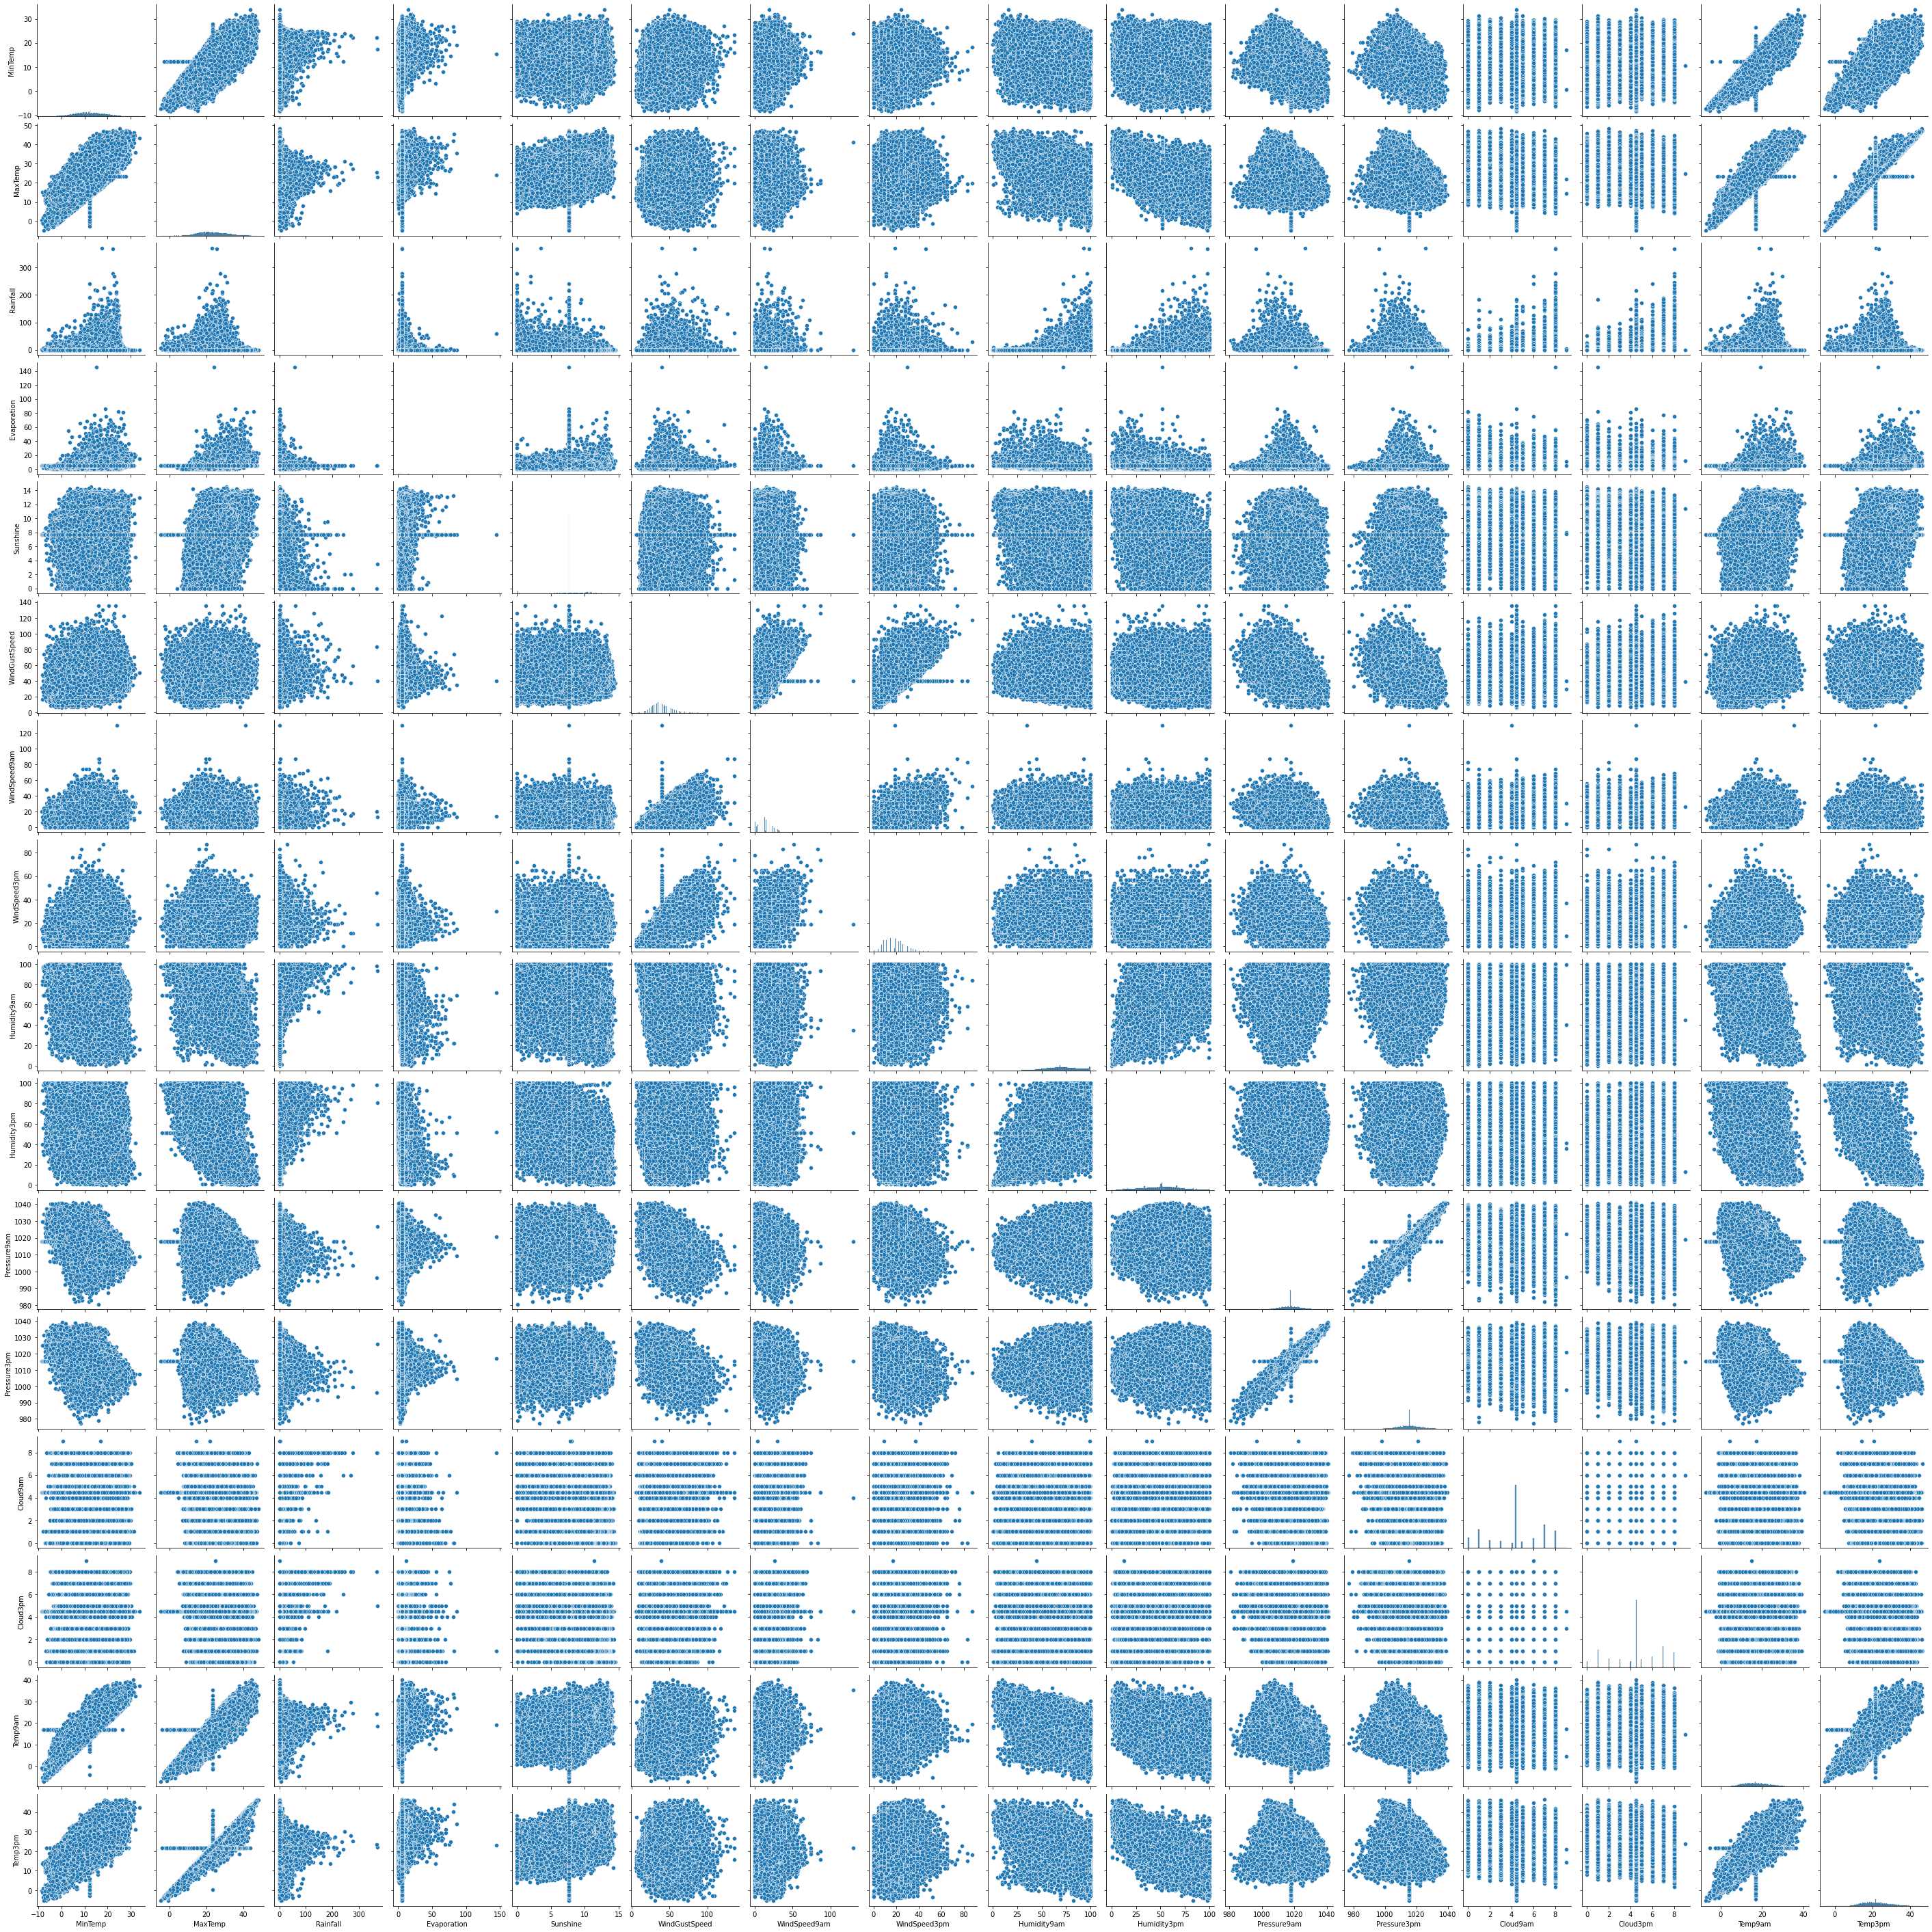

In [ ]:
sns.pairplot(data[dig])

Using this plot, we can see, that some of time based features had a high positive correlation with themselfs. So, we may want drop one of them from each pair.

I will use cap equal to 0.05. It just heuristic and you may save them in data. Different decision can give different advantages, for example, the fewer features, the higher the models speed and vice versa.

In [ ]:
drop_features = []

for feature, corr in zip(data[features].corrwith(target).index, data[features].corrwith(target).values):
    if np.abs(corr) < 0.05:
        drop_features.append(feature)

## 2.3 Data standartization

All machine learning algorithms prefer data with same scale, so lets subtract from each column it mean value and devide by standard deviation.

In [ ]:
for d in dig:
  data[d] = (data[d] - data[d].mean()) / data[d].std()

So, if we look on new digital columns distribution, we can see, that each mean value is equal to zero and std is equal to unit.

array([[<AxesSubplot:title={'center':'MinTemp'}>,
        <AxesSubplot:title={'center':'MaxTemp'}>,
        <AxesSubplot:title={'center':'Rainfall'}>,
        <AxesSubplot:title={'center':'Evaporation'}>],
       [<AxesSubplot:title={'center':'Sunshine'}>,
        <AxesSubplot:title={'center':'WindGustSpeed'}>,
        <AxesSubplot:title={'center':'WindSpeed9am'}>,
        <AxesSubplot:title={'center':'WindSpeed3pm'}>],
       [<AxesSubplot:title={'center':'Humidity9am'}>,
        <AxesSubplot:title={'center':'Humidity3pm'}>,
        <AxesSubplot:title={'center':'Pressure9am'}>,
        <AxesSubplot:title={'center':'Pressure3pm'}>],
       [<AxesSubplot:title={'center':'Cloud9am'}>,
        <AxesSubplot:title={'center':'Cloud3pm'}>,
        <AxesSubplot:title={'center':'Temp9am'}>,
        <AxesSubplot:title={'center':'Temp3pm'}>]], dtype=object)

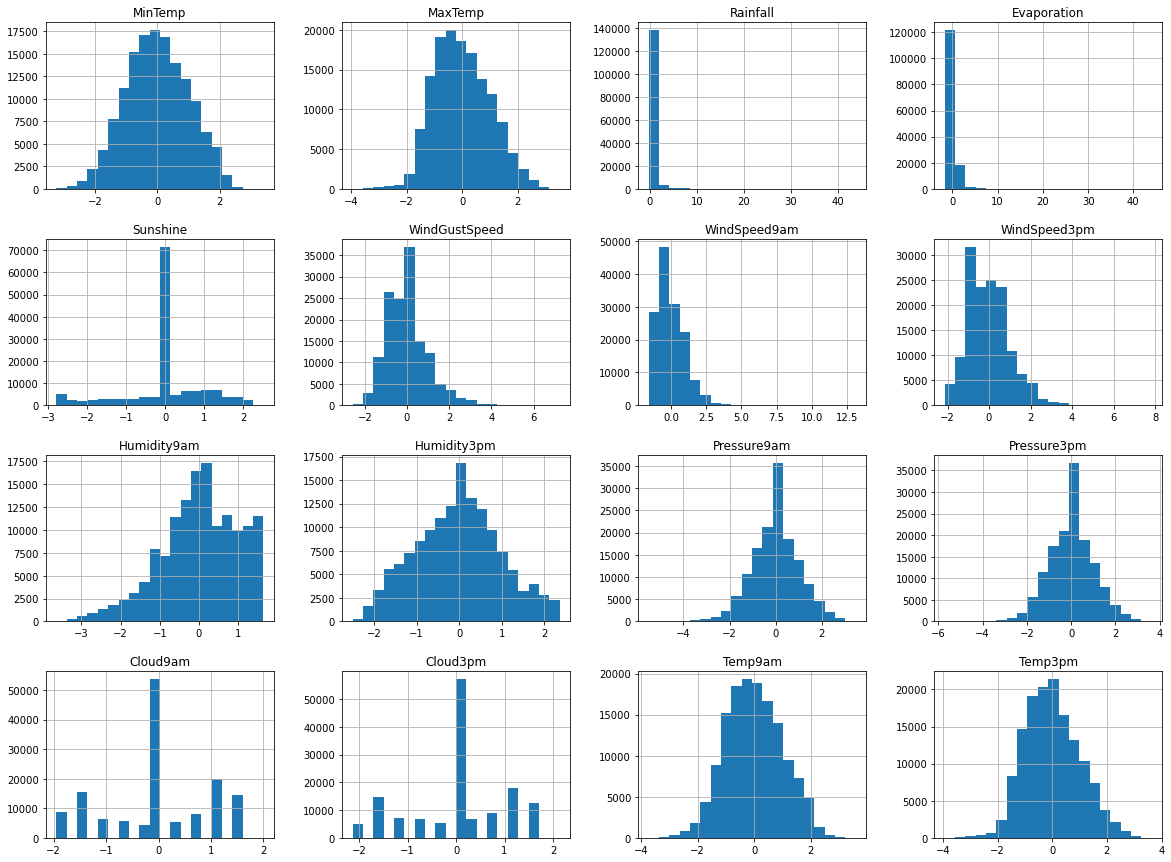

In [ ]:
data[dig].hist(figsize=(20, 15), bins=20)

## 3. Model selection

## 3.1 Parameters selection

The next step is chose and prepare model for predict target.

Firstly i will take the best algorithms for kaggle competitors - XGBCLassifier().

Separate data for train and test subsets. Also i create the new features list without *drop_features*

In [ ]:
new_features = [feature for feature in features if feature not in drop_features]

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(
    data[new_features], target, random_state=100, test_size=0.2, shuffle=False) # shuffle False because data is time series.

In [ ]:
clf = xgb.XGBClassifier(seed=123)
clf.fit(xtrain, ytrain)
clf.score(xtest, ytest)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8624775835999859

Not bad for first result. You can compare it with old features list, may be more is better?

In [ ]:
xtrain_old, xtest_old, ytrain_old, ytest_old = train_test_split(
    data[features], target, random_state=100, test_size=0.2, shuffle=False)

clf_old = xgb.XGBClassifier(seed=123)
clf_old.fit(xtrain_old, ytrain_old)
clf_old.score(xtest_old, ytest_old)

[19:33:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8483069024930553

But i will choose *LGBMClassifier*, cause it more lighter, faster and accurate than *XGBClassifier*.

In [ ]:
lgb_model = LGBMClassifier(random_state=123)
lgb_model.fit(xtrain, ytrain)
lgb_model.score(xtest, ytest)

0.8643060585815253

Also we can go through feature selection procedure.

* Create parameters dictionary
* Using optuna we choose the better one combination of them

In [ ]:
lgb_train = lightgbm.Dataset(xtrain, ytrain)
lgb_eval = lightgbm.Dataset(xtest, ytest)

def create_model(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 32, 512),
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.05, 0.5),
            'max_depth': trial.suggest_int('max_depth', 3, 18),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 8),
            'min_child_samples': trial.suggest_int('min_child_samples', 4, 80),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 200, 600),
            'random_state': 123
        }
    model = LGBMClassifier(**params)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(xtrain, ytrain)
    preds = model.predict_proba(xtest)[:, 1]
    score = roc_auc_score(ytest, preds)
    return score

In [ ]:
sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100) # you can increase n_trials number for better result

[I 2021-02-18 19:33:52,764] A new study created in memory with name: no-name-96076538-2883-4895-9b03-0dc5e073907b


[LightGBM] [Warning] bagging_fraction is set=0.8316813818713378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8316813818713378
[LightGBM] [Warning] feature_fraction is set=0.7307888614497348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7307888614497348
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:34:06,552] Trial 0 finished with value: 0.8734993608562165 and parameters: {'num_leaves': 397, 'learning_rate': 0.17876270072767075, 'max_depth': 15, 'min_child_weight': 3, 'feature_fraction': 0.7307888614497348, 'bagging_fraction': 0.8316813818713378, 'bagging_freq': 4, 'min_child_samples': 61, 'reg_alpha': 0.7016387837751591, 'reg_lambda': 0.003010494989157965, 'n_estimators': 326}. Best is trial 0 with value: 0.8734993608562165.


[LightGBM] [Warning] bagging_fraction is set=0.6631433468077746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6631433468077746
[LightGBM] [Warning] feature_fraction is set=0.837429824430425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837429824430425
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:34:15,264] Trial 1 finished with value: 0.8685189448576068 and parameters: {'num_leaves': 79, 'learning_rate': 0.22645288318736773, 'max_depth': 17, 'min_child_weight': 1, 'feature_fraction': 0.837429824430425, 'bagging_fraction': 0.6631433468077746, 'bagging_freq': 6, 'min_child_samples': 40, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943, 'n_estimators': 511}. Best is trial 0 with value: 0.8734993608562165.


[LightGBM] [Warning] bagging_fraction is set=0.7806405751307927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806405751307927
[LightGBM] [Warning] feature_fraction is set=0.7190965522581196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7190965522581196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-02-18 19:34:25,050] Trial 2 finished with value: 0.8780466661809743 and parameters: {'num_leaves': 483, 'learning_rate': 0.12895329026637165, 'max_depth': 10, 'min_child_weight': 3, 'feature_fraction': 0.7190965522581196, 'bagging_fraction': 0.7806405751307927, 'bagging_freq': 1, 'min_child_samples': 11, 'reg_alpha': 0.006246584207473313, 'reg_lambda': 0.0007730152921514658, 'n_estimators': 380}. Best is trial 2 with value: 0.8780466661809743.


[LightGBM] [Warning] bagging_fraction is set=0.7785856743126927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7785856743126927
[LightGBM] [Warning] feature_fraction is set=0.5762284278332976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762284278332976
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:34:39,106] Trial 3 finished with value: 0.870644480773854 and parameters: {'num_leaves': 390, 'learning_rate': 0.19533151123393022, 'max_depth': 9, 'min_child_weight': 3, 'feature_fraction': 0.5762284278332976, 'bagging_fraction': 0.7785856743126927, 'bagging_freq': 3, 'min_child_samples': 73, 'reg_alpha': 2.9485560066017848e-05, 'reg_lambda': 2.798350478519381e-05, 'n_estimators': 594}. Best is trial 2 with value: 0.8780466661809743.


[LightGBM] [Warning] bagging_fraction is set=0.9360334978702809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9360334978702809
[LightGBM] [Warning] feature_fraction is set=0.655810784177685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.655810784177685
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:34:45,864] Trial 4 finished with value: 0.8790932729495337 and parameters: {'num_leaves': 310, 'learning_rate': 0.2416236306331226, 'max_depth': 7, 'min_child_weight': 16, 'feature_fraction': 0.655810784177685, 'bagging_fraction': 0.9360334978702809, 'bagging_freq': 7, 'min_child_samples': 56, 'reg_alpha': 0.00010344116594294054, 'reg_lambda': 0.0009808974699196515, 'n_estimators': 408}. Best is trial 4 with value: 0.8790932729495337.


[LightGBM] [Warning] bagging_fraction is set=0.5502732192379041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5502732192379041
[LightGBM] [Warning] feature_fraction is set=0.9197854947300196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9197854947300196
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:34:56,175] Trial 5 finished with value: 0.8730037919605551 and parameters: {'num_leaves': 422, 'learning_rate': 0.1927784668191444, 'max_depth': 7, 'min_child_weight': 8, 'feature_fraction': 0.9197854947300196, 'bagging_fraction': 0.5502732192379041, 'bagging_freq': 4, 'min_child_samples': 62, 'reg_alpha': 0.7664402165049274, 'reg_lambda': 0.0001431795371231233, 'n_estimators': 512}. Best is trial 4 with value: 0.8790932729495337.


[LightGBM] [Warning] bagging_fraction is set=0.6600509435360007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600509435360007
[LightGBM] [Warning] feature_fraction is set=0.5696217605996191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5696217605996191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-02-18 19:34:59,317] Trial 6 finished with value: 0.8867774678539248 and parameters: {'num_leaves': 337, 'learning_rate': 0.26640145757685124, 'max_depth': 4, 'min_child_weight': 2, 'feature_fraction': 0.5696217605996191, 'bagging_fraction': 0.6600509435360007, 'bagging_freq': 1, 'min_child_samples': 60, 'reg_alpha': 5.325591565059095e-06, 'reg_lambda': 0.0032672024922779305, 'n_estimators': 267}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.9022316781799652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9022316781799652
[LightGBM] [Warning] feature_fraction is set=0.5609687846270347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5609687846270347
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:35:13,378] Trial 7 finished with value: 0.8725581528164646 and parameters: {'num_leaves': 171, 'learning_rate': 0.17051171980567315, 'max_depth': 10, 'min_child_weight': 10, 'feature_fraction': 0.5609687846270347, 'bagging_fraction': 0.9022316781799652, 'bagging_freq': 4, 'min_child_samples': 10, 'reg_alpha': 2.5291890112768953e-07, 'reg_lambda': 3.309265160403392e-06, 'n_estimators': 577}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.9311960957650838, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9311960957650838
[LightGBM] [Warning] feature_fraction is set=0.4574275099674323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4574275099674323
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:35:31,506] Trial 8 finished with value: 0.8760072184242809 and parameters: {'num_leaves': 230, 'learning_rate': 0.1374003322604469, 'max_depth': 14, 'min_child_weight': 7, 'feature_fraction': 0.4574275099674323, 'bagging_fraction': 0.9311960957650838, 'bagging_freq': 4, 'min_child_samples': 69, 'reg_alpha': 1.345964649065835e-08, 'reg_lambda': 0.0005694492634603255, 'n_estimators': 560}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.7069928304492099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7069928304492099
[LightGBM] [Warning] feature_fraction is set=0.46512537741109616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46512537741109616
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:35:46,266] Trial 9 finished with value: 0.8750273662298483 and parameters: {'num_leaves': 141, 'learning_rate': 0.12153183986512524, 'max_depth': 18, 'min_child_weight': 9, 'feature_fraction': 0.46512537741109616, 'bagging_fraction': 0.7069928304492099, 'bagging_freq': 4, 'min_child_samples': 33, 'reg_alpha': 5.58480621673485e-07, 'reg_lambda': 8.03216344891438e-06, 'n_estimators': 591}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.4058457284595227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4058457284595227
[LightGBM] [Warning] feature_fraction is set=0.42327567881618694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42327567881618694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-02-18 19:35:48,575] Trial 10 finished with value: 0.8818599934167607 and parameters: {'num_leaves': 291, 'learning_rate': 0.39438339872217365, 'max_depth': 3, 'min_child_weight': 16, 'feature_fraction': 0.42327567881618694, 'bagging_fraction': 0.4058457284595227, 'bagging_freq': 1, 'min_child_samples': 25, 'reg_alpha': 0.0016388373856115813, 'reg_lambda': 0.9795498693497441, 'n_estimators': 224}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.41933758978081204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41933758978081204
[LightGBM] [Warning] feature_fraction is set=0.40987755272245385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40987755272245385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-02-18 19:35:50,783] Trial 11 finished with value: 0.883427210677344 and parameters: {'num_leaves': 299, 'learning_rate': 0.39592723635129745, 'max_depth': 3, 'min_child_weight': 19, 'feature_fraction': 0.40987755272245385, 'bagging_fraction': 0.41933758978081204, 'bagging_freq': 1, 'min_child_samples': 26, 'reg_alpha': 0.007150686793180547, 'reg_lambda': 0.649506385004953, 'n_estimators': 205}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.4080695581983079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4080695581983079
[LightGBM] [Warning] feature_fraction is set=0.5412411145187843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5412411145187843
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-02-18 19:35:53,937] Trial 12 finished with value: 0.8831913179189622 and parameters: {'num_leaves': 335, 'learning_rate': 0.34598068821011974, 'max_depth': 3, 'min_child_weight': 20, 'feature_fraction': 0.5412411145187843, 'bagging_fraction': 0.4080695581983079, 'bagging_freq': 2, 'min_child_samples': 49, 'reg_alpha': 0.034983686693954706, 'reg_lambda': 2.5740828350961776e-08, 'n_estimators': 201}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.530361063768198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.530361063768198
[LightGBM] [Warning] feature_fraction is set=0.4123220851004537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4123220851004537
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-02-18 19:35:57,390] Trial 13 finished with value: 0.8801111171737416 and parameters: {'num_leaves': 247, 'learning_rate': 0.33090302432264584, 'max_depth': 5, 'min_child_weight': 14, 'feature_fraction': 0.4123220851004537, 'bagging_fraction': 0.530361063768198, 'bagging_freq': 2, 'min_child_samples': 25, 'reg_alpha': 0.0006068794884489604, 'reg_lambda': 0.27613966215282687, 'n_estimators': 273}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.5237471419251643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5237471419251643
[LightGBM] [Warning] feature_fraction is set=0.6350866191411967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6350866191411967
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-02-18 19:35:59,729] Trial 14 finished with value: 0.8836364276910709 and parameters: {'num_leaves': 497, 'learning_rate': 0.487154580951673, 'max_depth': 3, 'min_child_weight': 20, 'feature_fraction': 0.6350866191411967, 'bagging_fraction': 0.5237471419251643, 'bagging_freq': 1, 'min_child_samples': 78, 'reg_alpha': 3.3238706971127388e-06, 'reg_lambda': 0.10217544666647074, 'n_estimators': 269}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.5474176241862407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5474176241862407
[LightGBM] [Warning] feature_fraction is set=0.633929299631213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.633929299631213
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-02-18 19:36:03,914] Trial 15 finished with value: 0.8706945179342328 and parameters: {'num_leaves': 506, 'learning_rate': 0.45942518708606805, 'max_depth': 5, 'min_child_weight': 13, 'feature_fraction': 0.633929299631213, 'bagging_fraction': 0.5474176241862407, 'bagging_freq': 2, 'min_child_samples': 80, 'reg_alpha': 1.5466889522204646e-06, 'reg_lambda': 0.04343987235679478, 'n_estimators': 285}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.6239829612388459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6239829612388459
[LightGBM] [Warning] feature_fraction is set=0.7806994637455468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7806994637455468
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:36:08,497] Trial 16 finished with value: 0.8688388236317298 and parameters: {'num_leaves': 459, 'learning_rate': 0.49941243874982677, 'max_depth': 5, 'min_child_weight': 6, 'feature_fraction': 0.7806994637455468, 'bagging_fraction': 0.6239829612388459, 'bagging_freq': 6, 'min_child_samples': 76, 'reg_alpha': 1.3987251247585451e-08, 'reg_lambda': 0.05357416013440964, 'n_estimators': 362}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.48443483370722185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48443483370722185
[LightGBM] [Warning] feature_fraction is set=0.5111508336860752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5111508336860752
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-02-18 19:36:16,254] Trial 17 finished with value: 0.8588252308936457 and parameters: {'num_leaves': 359, 'learning_rate': 0.2968207772258364, 'max_depth': 13, 'min_child_weight': 13, 'feature_fraction': 0.5111508336860752, 'bagging_fraction': 0.48443483370722185, 'bagging_freq': 1, 'min_child_samples': 67, 'reg_alpha': 2.90539194984628e-06, 'reg_lambda': 0.026469443492973657, 'n_estimators': 259}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.604811397148291, subsample=1.0 will be ignored. Current value: bagging_fraction=0.604811397148291
[LightGBM] [Warning] feature_fraction is set=0.6321920686220492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6321920686220492
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:36:23,447] Trial 18 finished with value: 0.8737553160455072 and parameters: {'num_leaves': 448, 'learning_rate': 0.27089565478203825, 'max_depth': 7, 'min_child_weight': 18, 'feature_fraction': 0.6321920686220492, 'bagging_fraction': 0.604811397148291, 'bagging_freq': 3, 'min_child_samples': 80, 'reg_alpha': 6.069499609911567e-08, 'reg_lambda': 4.1478711224201333e-07, 'n_estimators': 446}. Best is trial 6 with value: 0.8867774678539248.


[LightGBM] [Warning] bagging_fraction is set=0.7100023433941341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100023433941341
[LightGBM] [Warning] feature_fraction is set=0.7831829142240834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831829142240834
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:36:28,167] Trial 19 finished with value: 0.8891156501936949 and parameters: {'num_leaves': 504, 'learning_rate': 0.08005824890282542, 'max_depth': 4, 'min_child_weight': 5, 'feature_fraction': 0.7831829142240834, 'bagging_fraction': 0.7100023433941341, 'bagging_freq': 8, 'min_child_samples': 50, 'reg_alpha': 5.786513429493856e-06, 'reg_lambda': 0.18114799577863513, 'n_estimators': 308}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.7338723582701736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7338723582701736
[LightGBM] [Warning] feature_fraction is set=0.8607132205026027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8607132205026027
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:36:38,252] Trial 20 finished with value: 0.8860585730304094 and parameters: {'num_leaves': 198, 'learning_rate': 0.05536060138170629, 'max_depth': 12, 'min_child_weight': 5, 'feature_fraction': 0.8607132205026027, 'bagging_fraction': 0.7338723582701736, 'bagging_freq': 8, 'min_child_samples': 50, 'reg_alpha': 2.302747051786793e-05, 'reg_lambda': 0.006225821949729254, 'n_estimators': 321}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.7226956062262305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7226956062262305
[LightGBM] [Warning] feature_fraction is set=0.974646726525352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.974646726525352
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:36:48,290] Trial 21 finished with value: 0.885209583124321 and parameters: {'num_leaves': 188, 'learning_rate': 0.06784402122281502, 'max_depth': 12, 'min_child_weight': 5, 'feature_fraction': 0.974646726525352, 'bagging_fraction': 0.7226956062262305, 'bagging_freq': 8, 'min_child_samples': 49, 'reg_alpha': 9.792561063537708e-05, 'reg_lambda': 0.006807072965615205, 'n_estimators': 324}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.7541963633508567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7541963633508567
[LightGBM] [Warning] feature_fraction is set=0.8698507406020425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8698507406020425
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:36:55,177] Trial 22 finished with value: 0.8873383796650944 and parameters: {'num_leaves': 94, 'learning_rate': 0.05842700034256977, 'max_depth': 12, 'min_child_weight': 1, 'feature_fraction': 0.8698507406020425, 'bagging_fraction': 0.7541963633508567, 'bagging_freq': 8, 'min_child_samples': 50, 'reg_alpha': 1.3958488550145688e-05, 'reg_lambda': 0.01219909382896781, 'n_estimators': 323}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.844255311676712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.844255311676712
[LightGBM] [Warning] feature_fraction is set=0.7917903187086803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7917903187086803
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:37:01,495] Trial 23 finished with value: 0.8883101915430478 and parameters: {'num_leaves': 35, 'learning_rate': 0.08708911495215016, 'max_depth': 8, 'min_child_weight': 1, 'feature_fraction': 0.7917903187086803, 'bagging_fraction': 0.844255311676712, 'bagging_freq': 7, 'min_child_samples': 39, 'reg_alpha': 1.2705797850866046e-07, 'reg_lambda': 0.26941926844392117, 'n_estimators': 347}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8600627152784712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600627152784712
[LightGBM] [Warning] feature_fraction is set=0.7977982319932555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7977982319932555
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:37:07,807] Trial 24 finished with value: 0.8876080985259154 and parameters: {'num_leaves': 43, 'learning_rate': 0.08951483693695467, 'max_depth': 8, 'min_child_weight': 1, 'feature_fraction': 0.7977982319932555, 'bagging_fraction': 0.8600627152784712, 'bagging_freq': 7, 'min_child_samples': 39, 'reg_alpha': 5.4045123707982405e-08, 'reg_lambda': 0.181206499199579, 'n_estimators': 416}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8545808936973167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8545808936973167
[LightGBM] [Warning] feature_fraction is set=0.7560135481493938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7560135481493938
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:37:14,756] Trial 25 finished with value: 0.8883477769537647 and parameters: {'num_leaves': 45, 'learning_rate': 0.09124167436041841, 'max_depth': 8, 'min_child_weight': 1, 'feature_fraction': 0.7560135481493938, 'bagging_fraction': 0.8545808936973167, 'bagging_freq': 7, 'min_child_samples': 40, 'reg_alpha': 9.774665919705733e-08, 'reg_lambda': 0.21041419313007276, 'n_estimators': 420}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8450750488746833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8450750488746833
[LightGBM] [Warning] feature_fraction is set=0.7646885876278862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7646885876278862
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:37:22,505] Trial 26 finished with value: 0.8876039556147526 and parameters: {'num_leaves': 48, 'learning_rate': 0.09666205875605566, 'max_depth': 8, 'min_child_weight': 4, 'feature_fraction': 0.7646885876278862, 'bagging_fraction': 0.8450750488746833, 'bagging_freq': 7, 'min_child_samples': 34, 'reg_alpha': 1.5970874859142562e-07, 'reg_lambda': 0.8789461031976393, 'n_estimators': 454}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.9736778685185898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9736778685185898
[LightGBM] [Warning] feature_fraction is set=0.9248084771906535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9248084771906535
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:37:29,346] Trial 27 finished with value: 0.8880115183364329 and parameters: {'num_leaves': 116, 'learning_rate': 0.08794690282927939, 'max_depth': 6, 'min_child_weight': 1, 'feature_fraction': 0.9248084771906535, 'bagging_fraction': 0.9736778685185898, 'bagging_freq': 6, 'min_child_samples': 44, 'reg_alpha': 7.406479446596236e-07, 'reg_lambda': 0.3394721831879809, 'n_estimators': 374}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8146318279258201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8146318279258201
[LightGBM] [Warning] feature_fraction is set=0.8079950203889443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8079950203889443
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:37:36,391] Trial 28 finished with value: 0.8829849702548185 and parameters: {'num_leaves': 43, 'learning_rate': 0.1472768311453319, 'max_depth': 9, 'min_child_weight': 6, 'feature_fraction': 0.8079950203889443, 'bagging_fraction': 0.8146318279258201, 'bagging_freq': 7, 'min_child_samples': 19, 'reg_alpha': 3.4409005695968994e-08, 'reg_lambda': 0.1296004282102877, 'n_estimators': 443}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8758126266540054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8758126266540054
[LightGBM] [Warning] feature_fraction is set=0.6949622532314571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6949622532314571
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:37:42,131] Trial 29 finished with value: 0.8879201057688287 and parameters: {'num_leaves': 141, 'learning_rate': 0.09354266913666764, 'max_depth': 6, 'min_child_weight': 3, 'feature_fraction': 0.6949622532314571, 'bagging_fraction': 0.8758126266540054, 'bagging_freq': 5, 'min_child_samples': 32, 'reg_alpha': 1.9749038791583172e-07, 'reg_lambda': 0.036096439452443126, 'n_estimators': 338}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.9979872025872168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9979872025872168
[LightGBM] [Warning] feature_fraction is set=0.7427596756320436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7427596756320436
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:37:50,030] Trial 30 finished with value: 0.8813754185797964 and parameters: {'num_leaves': 61, 'learning_rate': 0.1626072405592579, 'max_depth': 11, 'min_child_weight': 5, 'feature_fraction': 0.7427596756320436, 'bagging_fraction': 0.9979872025872168, 'bagging_freq': 5, 'min_child_samples': 44, 'reg_alpha': 6.668203175369884e-07, 'reg_lambda': 0.6769054867461377, 'n_estimators': 483}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.9881007807598552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881007807598552
[LightGBM] [Warning] feature_fraction is set=0.9063807412497941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9063807412497941
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:37:56,985] Trial 31 finished with value: 0.8878487786483074 and parameters: {'num_leaves': 111, 'learning_rate': 0.10429845774485552, 'max_depth': 6, 'min_child_weight': 1, 'feature_fraction': 0.9063807412497941, 'bagging_fraction': 0.9881007807598552, 'bagging_freq': 6, 'min_child_samples': 44, 'reg_alpha': 6.411585013310765e-07, 'reg_lambda': 0.34111833671167874, 'n_estimators': 369}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.9539116020258314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539116020258314
[LightGBM] [Warning] feature_fraction is set=0.9862360003666791, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9862360003666791
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:38:06,431] Trial 32 finished with value: 0.8887382923632153 and parameters: {'num_leaves': 121, 'learning_rate': 0.054671455502302395, 'max_depth': 8, 'min_child_weight': 2, 'feature_fraction': 0.9862360003666791, 'bagging_fraction': 0.9539116020258314, 'bagging_freq': 6, 'min_child_samples': 38, 'reg_alpha': 1.2141771423800456e-07, 'reg_lambda': 0.1532750296106563, 'n_estimators': 352}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8100839170059425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8100839170059425
[LightGBM] [Warning] feature_fraction is set=0.8260636311949442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8260636311949442
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:38:12,692] Trial 33 finished with value: 0.8890469008845637 and parameters: {'num_leaves': 74, 'learning_rate': 0.051736077087386034, 'max_depth': 9, 'min_child_weight': 2, 'feature_fraction': 0.8260636311949442, 'bagging_fraction': 0.8100839170059425, 'bagging_freq': 8, 'min_child_samples': 37, 'reg_alpha': 1.0340431100581684e-08, 'reg_lambda': 0.07062513171973869, 'n_estimators': 298}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8042236581096633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8042236581096633
[LightGBM] [Warning] feature_fraction is set=0.9880743090220612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9880743090220612
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:38:19,604] Trial 34 finished with value: 0.887933976849167 and parameters: {'num_leaves': 77, 'learning_rate': 0.05027164798315174, 'max_depth': 9, 'min_child_weight': 3, 'feature_fraction': 0.9880743090220612, 'bagging_fraction': 0.8042236581096633, 'bagging_freq': 8, 'min_child_samples': 36, 'reg_alpha': 1.208058725480361e-08, 'reg_lambda': 0.02101817355046851, 'n_estimators': 300}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.9205142028406827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9205142028406827
[LightGBM] [Warning] feature_fraction is set=0.693402604482616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.693402604482616
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:38:29,011] Trial 35 finished with value: 0.8818430074809929 and parameters: {'num_leaves': 138, 'learning_rate': 0.12095565510272108, 'max_depth': 16, 'min_child_weight': 4, 'feature_fraction': 0.693402604482616, 'bagging_fraction': 0.9205142028406827, 'bagging_freq': 6, 'min_child_samples': 54, 'reg_alpha': 3.0509895876918006e-08, 'reg_lambda': 0.0695877432416873, 'n_estimators': 394}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.7831795256304577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7831795256304577
[LightGBM] [Warning] feature_fraction is set=0.8314408446436931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314408446436931
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:38:34,775] Trial 36 finished with value: 0.8768004631590549 and parameters: {'num_leaves': 95, 'learning_rate': 0.21801361975355515, 'max_depth': 10, 'min_child_weight': 2, 'feature_fraction': 0.8314408446436931, 'bagging_fraction': 0.7831795256304577, 'bagging_freq': 8, 'min_child_samples': 29, 'reg_alpha': 8.54620575156272e-08, 'reg_lambda': 0.0018724674931622106, 'n_estimators': 241}. Best is trial 19 with value: 0.8891156501936949.


[LightGBM] [Warning] bagging_fraction is set=0.8889441691091696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8889441691091696
[LightGBM] [Warning] feature_fraction is set=0.7311176148992405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7311176148992405
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:38:40,717] Trial 37 finished with value: 0.8894892947482433 and parameters: {'num_leaves': 71, 'learning_rate': 0.06780162576692855, 'max_depth': 11, 'min_child_weight': 2, 'feature_fraction': 0.7311176148992405, 'bagging_fraction': 0.8889441691091696, 'bagging_freq': 7, 'min_child_samples': 15, 'reg_alpha': 1.0222457949108164e-08, 'reg_lambda': 0.014313735541066753, 'n_estimators': 299}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.6789062900930006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6789062900930006
[LightGBM] [Warning] feature_fraction is set=0.7191208344548825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7191208344548825
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:38:48,622] Trial 38 finished with value: 0.8880090709500235 and parameters: {'num_leaves': 163, 'learning_rate': 0.05307814813968354, 'max_depth': 11, 'min_child_weight': 4, 'feature_fraction': 0.7191208344548825, 'bagging_fraction': 0.6789062900930006, 'bagging_freq': 5, 'min_child_samples': 17, 'reg_alpha': 6.997239057629315e-05, 'reg_lambda': 0.00034565749626214507, 'n_estimators': 292}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.9631621867419777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631621867419777
[LightGBM] [Warning] feature_fraction is set=0.9626664252757549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9626664252757549
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:38:54,454] Trial 39 finished with value: 0.8881951873979884 and parameters: {'num_leaves': 75, 'learning_rate': 0.06814863337762442, 'max_depth': 15, 'min_child_weight': 2, 'feature_fraction': 0.9626664252757549, 'bagging_fraction': 0.9631621867419777, 'bagging_freq': 7, 'min_child_samples': 7, 'reg_alpha': 1.0214534913046046e-08, 'reg_lambda': 0.00253374402131582, 'n_estimators': 303}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.8944503877313665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8944503877313665
[LightGBM] [Warning] feature_fraction is set=0.6683415150911179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6683415150911179
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:39:03,659] Trial 40 finished with value: 0.8814598572469429 and parameters: {'num_leaves': 205, 'learning_rate': 0.12098165602442501, 'max_depth': 10, 'min_child_weight': 7, 'feature_fraction': 0.6683415150911179, 'bagging_fraction': 0.8944503877313665, 'bagging_freq': 8, 'min_child_samples': 18, 'reg_alpha': 6.714978556171373e-06, 'reg_lambda': 0.0001764318296027326, 'n_estimators': 341}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.880702316917144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.880702316917144
[LightGBM] [Warning] feature_fraction is set=0.7440056193346795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7440056193346795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:39:13,962] Trial 41 finished with value: 0.8869989755041018 and parameters: {'num_leaves': 105, 'learning_rate': 0.07383692550668866, 'max_depth': 9, 'min_child_weight': 2, 'feature_fraction': 0.7440056193346795, 'bagging_fraction': 0.880702316917144, 'bagging_freq': 7, 'min_child_samples': 60, 'reg_alpha': 2.0709219587779823e-08, 'reg_lambda': 0.013706343783570671, 'n_estimators': 397}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.7645330020937481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7645330020937481
[LightGBM] [Warning] feature_fraction is set=0.8489338467546225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8489338467546225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:39:21,383] Trial 42 finished with value: 0.8811195938154868 and parameters: {'num_leaves': 62, 'learning_rate': 0.15888116631735577, 'max_depth': 7, 'min_child_weight': 3, 'feature_fraction': 0.8489338467546225, 'bagging_fraction': 0.7645330020937481, 'bagging_freq': 6, 'min_child_samples': 55, 'reg_alpha': 4.24376018045866e-07, 'reg_lambda': 0.06692705396038957, 'n_estimators': 417}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.9477605467724179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477605467724179
[LightGBM] [Warning] feature_fraction is set=0.8228818052978126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8228818052978126
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:39:27,193] Trial 43 finished with value: 0.8789313695156985 and parameters: {'num_leaves': 125, 'learning_rate': 0.19942851903984188, 'max_depth': 11, 'min_child_weight': 2, 'feature_fraction': 0.8228818052978126, 'bagging_fraction': 0.9477605467724179, 'bagging_freq': 7, 'min_child_samples': 41, 'reg_alpha': 1.7551508966448471e-06, 'reg_lambda': 0.9189033261299591, 'n_estimators': 247}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.8050001797867802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8050001797867802
[LightGBM] [Warning] feature_fraction is set=0.75720525733364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75720525733364
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:39:31,512] Trial 44 finished with value: 0.8868160813203746 and parameters: {'num_leaves': 32, 'learning_rate': 0.1141447389033986, 'max_depth': 9, 'min_child_weight': 4, 'feature_fraction': 0.75720525733364, 'bagging_fraction': 0.8050001797867802, 'bagging_freq': 8, 'min_child_samples': 37, 'reg_alpha': 1.0190527612871887e-08, 'reg_lambda': 0.11582281938765385, 'n_estimators': 312}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.9113928370675086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9113928370675086
[LightGBM] [Warning] feature_fraction is set=0.7168860662798054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168860662798054
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:39:38,072] Trial 45 finished with value: 0.8855107267335183 and parameters: {'num_leaves': 71, 'learning_rate': 0.13814986463216367, 'max_depth': 8, 'min_child_weight': 8, 'feature_fraction': 0.7168860662798054, 'bagging_fraction': 0.9113928370675086, 'bagging_freq': 7, 'min_child_samples': 31, 'reg_alpha': 4.20709109891667e-08, 'reg_lambda': 2.2820292543378758e-05, 'n_estimators': 284}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.8187011157156833, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187011157156833
[LightGBM] [Warning] feature_fraction is set=0.9014682272309704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9014682272309704
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:39:48,534] Trial 46 finished with value: 0.885619838738257 and parameters: {'num_leaves': 157, 'learning_rate': 0.05065631445300659, 'max_depth': 13, 'min_child_weight': 2, 'feature_fraction': 0.9014682272309704, 'bagging_fraction': 0.8187011157156833, 'bagging_freq': 6, 'min_child_samples': 46, 'reg_alpha': 2.46272360065979e-07, 'reg_lambda': 0.004758230831033738, 'n_estimators': 345}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.94789653866441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94789653866441
[LightGBM] [Warning] feature_fraction is set=0.6034164383346443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6034164383346443
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:39:55,075] Trial 47 finished with value: 0.8832175103239813 and parameters: {'num_leaves': 264, 'learning_rate': 0.1819823766323046, 'max_depth': 7, 'min_child_weight': 3, 'feature_fraction': 0.6034164383346443, 'bagging_fraction': 0.94789653866441, 'bagging_freq': 8, 'min_child_samples': 28, 'reg_alpha': 0.00026581841109889464, 'reg_lambda': 0.41399036649597665, 'n_estimators': 359}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.8638325269679691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8638325269679691
[LightGBM] [Warning] feature_fraction is set=0.6847198654097126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6847198654097126
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-02-18 19:39:59,679] Trial 48 finished with value: 0.8891761980731351 and parameters: {'num_leaves': 392, 'learning_rate': 0.0778341997827951, 'max_depth': 4, 'min_child_weight': 11, 'feature_fraction': 0.6847198654097126, 'bagging_fraction': 0.8638325269679691, 'bagging_freq': 7, 'min_child_samples': 22, 'reg_alpha': 0.16699666731251167, 'reg_lambda': 0.02013139734280915, 'n_estimators': 381}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.6393174026702998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6393174026702998
[LightGBM] [Warning] feature_fraction is set=0.6643087444151076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643087444151076
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-02-18 19:40:02,551] Trial 49 finished with value: 0.8885948479002285 and parameters: {'num_leaves': 390, 'learning_rate': 0.07188143203182433, 'max_depth': 4, 'min_child_weight': 11, 'feature_fraction': 0.6643087444151076, 'bagging_fraction': 0.6393174026702998, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 0.2049948511697791, 'reg_lambda': 0.0010014795686642166, 'n_estimators': 251}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.6959900701117374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6959900701117374
[LightGBM] [Warning] feature_fraction is set=0.8784483405453296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8784483405453296
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:05,676] Trial 50 finished with value: 0.8894536196798959 and parameters: {'num_leaves': 423, 'learning_rate': 0.13905827920115166, 'max_depth': 4, 'min_child_weight': 11, 'feature_fraction': 0.8784483405453296, 'bagging_fraction': 0.6959900701117374, 'bagging_freq': 5, 'min_child_samples': 15, 'reg_alpha': 0.23505178241563132, 'reg_lambda': 0.01770603081160155, 'n_estimators': 227}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.6874512089646684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6874512089646684
[LightGBM] [Warning] feature_fraction is set=0.8821497202672564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8821497202672564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:09,063] Trial 51 finished with value: 0.8885101867434085 and parameters: {'num_leaves': 425, 'learning_rate': 0.10950296312098312, 'max_depth': 4, 'min_child_weight': 11, 'feature_fraction': 0.8821497202672564, 'bagging_fraction': 0.6874512089646684, 'bagging_freq': 5, 'min_child_samples': 22, 'reg_alpha': 0.2096498947943304, 'reg_lambda': 0.01516585708342112, 'n_estimators': 277}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.7156967676009744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156967676009744
[LightGBM] [Warning] feature_fraction is set=0.9382032432539793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9382032432539793
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:40:14,618] Trial 52 finished with value: 0.8877973068131371 and parameters: {'num_leaves': 368, 'learning_rate': 0.07585503582145282, 'max_depth': 4, 'min_child_weight': 10, 'feature_fraction': 0.9382032432539793, 'bagging_fraction': 0.7156967676009744, 'bagging_freq': 6, 'min_child_samples': 13, 'reg_alpha': 0.023294406573166358, 'reg_lambda': 0.03232984619335245, 'n_estimators': 387}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.5986404888379955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5986404888379955
[LightGBM] [Warning] feature_fraction is set=0.7775913954843034, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775913954843034
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:18,131] Trial 53 finished with value: 0.8891675516640969 and parameters: {'num_leaves': 489, 'learning_rate': 0.1409645544028255, 'max_depth': 5, 'min_child_weight': 12, 'feature_fraction': 0.7775913954843034, 'bagging_fraction': 0.5986404888379955, 'bagging_freq': 5, 'min_child_samples': 4, 'reg_alpha': 0.5176855875546613, 'reg_lambda': 0.010750860216976636, 'n_estimators': 223}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.5852964429048924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5852964429048924
[LightGBM] [Warning] feature_fraction is set=0.780359508203908, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.780359508203908
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:40:21,185] Trial 54 finished with value: 0.8879773239752233 and parameters: {'num_leaves': 474, 'learning_rate': 0.13628753697079132, 'max_depth': 5, 'min_child_weight': 12, 'feature_fraction': 0.780359508203908, 'bagging_fraction': 0.5852964429048924, 'bagging_freq': 3, 'min_child_samples': 7, 'reg_alpha': 0.8075849438990316, 'reg_lambda': 0.001706025326934813, 'n_estimators': 218}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.6604404602639468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6604404602639468
[LightGBM] [Warning] feature_fraction is set=0.8171350704256725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8171350704256725
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:40:23,555] Trial 55 finished with value: 0.8874005386766537 and parameters: {'num_leaves': 422, 'learning_rate': 0.25216426218525284, 'max_depth': 3, 'min_child_weight': 14, 'feature_fraction': 0.8171350704256725, 'bagging_fraction': 0.6604404602639468, 'bagging_freq': 4, 'min_child_samples': 5, 'reg_alpha': 0.22474435979326435, 'reg_lambda': 0.009561208759698516, 'n_estimators': 218}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.5816450419674486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5816450419674486
[LightGBM] [Warning] feature_fraction is set=0.8366143888543105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366143888543105
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:25,868] Trial 56 finished with value: 0.8881501984515823 and parameters: {'num_leaves': 512, 'learning_rate': 0.21167801519882795, 'max_depth': 4, 'min_child_weight': 9, 'feature_fraction': 0.8366143888543105, 'bagging_fraction': 0.5816450419674486, 'bagging_freq': 5, 'min_child_samples': 15, 'reg_alpha': 0.07305387698176667, 'reg_lambda': 0.0033173164193714953, 'n_estimators': 200}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.4751341472180339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4751341472180339
[LightGBM] [Warning] feature_fraction is set=0.7212518511665564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7212518511665564
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:40:29,654] Trial 57 finished with value: 0.8858163584964756 and parameters: {'num_leaves': 484, 'learning_rate': 0.15471655066994344, 'max_depth': 5, 'min_child_weight': 13, 'feature_fraction': 0.7212518511665564, 'bagging_fraction': 0.4751341472180339, 'bagging_freq': 3, 'min_child_samples': 22, 'reg_alpha': 0.003894045109858394, 'reg_lambda': 0.02450044994402977, 'n_estimators': 267}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.7426455071829217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7426455071829217
[LightGBM] [Warning] feature_fraction is set=0.7701809798270898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7701809798270898
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:40:33,485] Trial 58 finished with value: 0.8885293822317967 and parameters: {'num_leaves': 443, 'learning_rate': 0.12900725221874065, 'max_depth': 6, 'min_child_weight': 15, 'feature_fraction': 0.7701809798270898, 'bagging_fraction': 0.7426455071829217, 'bagging_freq': 4, 'min_child_samples': 10, 'reg_alpha': 0.5475373387707483, 'reg_lambda': 0.061155390307551856, 'n_estimators': 238}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.7037677404352234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7037677404352234
[LightGBM] [Warning] feature_fraction is set=0.8682605156171461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8682605156171461
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:36,650] Trial 59 finished with value: 0.8875836169897657 and parameters: {'num_leaves': 399, 'learning_rate': 0.10843261001788367, 'max_depth': 3, 'min_child_weight': 12, 'feature_fraction': 0.8682605156171461, 'bagging_fraction': 0.7037677404352234, 'bagging_freq': 5, 'min_child_samples': 22, 'reg_alpha': 0.10055883002123657, 'reg_lambda': 0.0006649163221332483, 'n_estimators': 309}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.6282811809358133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6282811809358133
[LightGBM] [Warning] feature_fraction is set=0.6767385631846029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6767385631846029
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:40:39,961] Trial 60 finished with value: 0.8882390945842576 and parameters: {'num_leaves': 470, 'learning_rate': 0.08205286223191949, 'max_depth': 4, 'min_child_weight': 10, 'feature_fraction': 0.6767385631846029, 'bagging_fraction': 0.6282811809358133, 'bagging_freq': 4, 'min_child_samples': 5, 'reg_alpha': 0.013583638266298754, 'reg_lambda': 0.0047668073650404316, 'n_estimators': 232}. Best is trial 37 with value: 0.8894892947482433.


[LightGBM] [Warning] bagging_fraction is set=0.8842719010448791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8842719010448791
[LightGBM] [Warning] feature_fraction is set=0.7986393794587728, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7986393794587728
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:46,006] Trial 61 finished with value: 0.8897952487376243 and parameters: {'num_leaves': 317, 'learning_rate': 0.06375089445543877, 'max_depth': 5, 'min_child_weight': 12, 'feature_fraction': 0.7986393794587728, 'bagging_fraction': 0.8842719010448791, 'bagging_freq': 5, 'min_child_samples': 9, 'reg_alpha': 0.4270070401987772, 'reg_lambda': 0.10618981030599704, 'n_estimators': 328}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.7772904340549686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7772904340549686
[LightGBM] [Warning] feature_fraction is set=0.7943536196260053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7943536196260053
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:50,315] Trial 62 finished with value: 0.8897429176319904 and parameters: {'num_leaves': 308, 'learning_rate': 0.06164680125364488, 'max_depth': 5, 'min_child_weight': 12, 'feature_fraction': 0.7943536196260053, 'bagging_fraction': 0.7772904340549686, 'bagging_freq': 5, 'min_child_samples': 10, 'reg_alpha': 0.4765108802070603, 'reg_lambda': 0.009229595870504112, 'n_estimators': 258}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.7892133641656347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7892133641656347
[LightGBM] [Warning] feature_fraction is set=0.7890812493988943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7890812493988943
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:53,943] Trial 63 finished with value: 0.8883172344920247 and parameters: {'num_leaves': 317, 'learning_rate': 0.17787889234413082, 'max_depth': 5, 'min_child_weight': 12, 'feature_fraction': 0.7890812493988943, 'bagging_fraction': 0.7892133641656347, 'bagging_freq': 5, 'min_child_samples': 9, 'reg_alpha': 0.4981460591875264, 'reg_lambda': 0.009571461904087853, 'n_estimators': 260}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8759018966189703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8759018966189703
[LightGBM] [Warning] feature_fraction is set=0.7360510855538219, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7360510855538219
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:40:58,068] Trial 64 finished with value: 0.8893549263295263 and parameters: {'num_leaves': 341, 'learning_rate': 0.10008894704686541, 'max_depth': 4, 'min_child_weight': 11, 'feature_fraction': 0.7360510855538219, 'bagging_fraction': 0.8759018966189703, 'bagging_freq': 5, 'min_child_samples': 14, 'reg_alpha': 0.06021433149969708, 'reg_lambda': 0.017708987479237406, 'n_estimators': 332}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8735217505797259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8735217505797259
[LightGBM] [Warning] feature_fraction is set=0.7425660962212549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7425660962212549
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:01,067] Trial 65 finished with value: 0.8876335467413364 and parameters: {'num_leaves': 342, 'learning_rate': 0.10296131530918547, 'max_depth': 3, 'min_child_weight': 11, 'feature_fraction': 0.7425660962212549, 'bagging_fraction': 0.8735217505797259, 'bagging_freq': 5, 'min_child_samples': 14, 'reg_alpha': 0.06312505477852302, 'reg_lambda': 0.0195096470219379, 'n_estimators': 228}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8310730344720628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8310730344720628
[LightGBM] [Warning] feature_fraction is set=0.7012205669768858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7012205669768858
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:41:05,655] Trial 66 finished with value: 0.8885260832469819 and parameters: {'num_leaves': 290, 'learning_rate': 0.1372996941726914, 'max_depth': 5, 'min_child_weight': 9, 'feature_fraction': 0.7012205669768858, 'bagging_fraction': 0.8310730344720628, 'bagging_freq': 4, 'min_child_samples': 4, 'reg_alpha': 0.3582451437740464, 'reg_lambda': 0.0013310226200846842, 'n_estimators': 329}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8877042811756255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877042811756255
[LightGBM] [Warning] feature_fraction is set=0.8028847450941778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8028847450941778
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:10,611] Trial 67 finished with value: 0.8894434235152004 and parameters: {'num_leaves': 317, 'learning_rate': 0.061693572929836564, 'max_depth': 6, 'min_child_weight': 14, 'feature_fraction': 0.8028847450941778, 'bagging_fraction': 0.8877042811756255, 'bagging_freq': 5, 'min_child_samples': 16, 'reg_alpha': 0.12556960182606286, 'reg_lambda': 0.00678442261854198, 'n_estimators': 283}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8941250586086134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8941250586086134
[LightGBM] [Warning] feature_fraction is set=0.8069906834099613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8069906834099613
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:41:16,076] Trial 68 finished with value: 0.8815464057299592 and parameters: {'num_leaves': 319, 'learning_rate': 0.28997698831707097, 'max_depth': 6, 'min_child_weight': 14, 'feature_fraction': 0.8069906834099613, 'bagging_fraction': 0.8941250586086134, 'bagging_freq': 4, 'min_child_samples': 20, 'reg_alpha': 0.12755737005623027, 'reg_lambda': 0.004060655840544211, 'n_estimators': 282}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.9279908766318281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9279908766318281
[LightGBM] [Warning] feature_fraction is set=0.6514936488100639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6514936488100639
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:20,499] Trial 69 finished with value: 0.8888080697280796 and parameters: {'num_leaves': 356, 'learning_rate': 0.06680495115735072, 'max_depth': 4, 'min_child_weight': 17, 'feature_fraction': 0.6514936488100639, 'bagging_fraction': 0.9279908766318281, 'bagging_freq': 5, 'min_child_samples': 16, 'reg_alpha': 0.03435177840190885, 'reg_lambda': 0.0003480600297768118, 'n_estimators': 334}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8630335083068672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8630335083068672
[LightGBM] [Warning] feature_fraction is set=0.6013559226031225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6013559226031225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:41:25,936] Trial 70 finished with value: 0.8888816601056252 and parameters: {'num_leaves': 378, 'learning_rate': 0.09808637765816552, 'max_depth': 6, 'min_child_weight': 13, 'feature_fraction': 0.6013559226031225, 'bagging_fraction': 0.8630335083068672, 'bagging_freq': 6, 'min_child_samples': 8, 'reg_alpha': 0.960512465096545, 'reg_lambda': 0.030347119626820164, 'n_estimators': 321}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.835608435795599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.835608435795599
[LightGBM] [Warning] feature_fraction is set=0.7382832122281693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7382832122281693
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:29,268] Trial 71 finished with value: 0.8889896826781692 and parameters: {'num_leaves': 283, 'learning_rate': 0.06153173634431777, 'max_depth': 5, 'min_child_weight': 12, 'feature_fraction': 0.7382832122281693, 'bagging_fraction': 0.835608435795599, 'bagging_freq': 5, 'min_child_samples': 11, 'reg_alpha': 0.30740562375592767, 'reg_lambda': 0.008109044290399128, 'n_estimators': 213}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8998449187334646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8998449187334646
[LightGBM] [Warning] feature_fraction is set=0.7645454238860752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7645454238860752
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:33,322] Trial 72 finished with value: 0.8892201436196928 and parameters: {'num_leaves': 335, 'learning_rate': 0.08568857261823976, 'max_depth': 5, 'min_child_weight': 15, 'feature_fraction': 0.7645454238860752, 'bagging_fraction': 0.8998449187334646, 'bagging_freq': 5, 'min_child_samples': 13, 'reg_alpha': 0.042580177794815745, 'reg_lambda': 0.014300528930932728, 'n_estimators': 255}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.9012702795132329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9012702795132329
[LightGBM] [Warning] feature_fraction is set=0.8517818697424516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8517818697424516
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:36,344] Trial 73 finished with value: 0.8874726943794075 and parameters: {'num_leaves': 335, 'learning_rate': 0.08280467600706151, 'max_depth': 3, 'min_child_weight': 15, 'feature_fraction': 0.8517818697424516, 'bagging_fraction': 0.9012702795132329, 'bagging_freq': 5, 'min_child_samples': 15, 'reg_alpha': 0.05070632367302993, 'reg_lambda': 0.048786130659389325, 'n_estimators': 254}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8828839306558047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8828839306558047
[LightGBM] [Warning] feature_fraction is set=0.7054651548894497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7054651548894497
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:41:41,749] Trial 74 finished with value: 0.8880441015655233 and parameters: {'num_leaves': 307, 'learning_rate': 0.09330235921604674, 'max_depth': 7, 'min_child_weight': 14, 'feature_fraction': 0.7054651548894497, 'bagging_fraction': 0.8828839306558047, 'bagging_freq': 4, 'min_child_samples': 20, 'reg_alpha': 0.015223079128609457, 'reg_lambda': 0.01828723320805549, 'n_estimators': 292}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.9181348644374371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9181348644374371
[LightGBM] [Warning] feature_fraction is set=0.7999396838167097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7999396838167097
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-02-18 19:41:46,848] Trial 75 finished with value: 0.8889606209235672 and parameters: {'num_leaves': 406, 'learning_rate': 0.06384235138547102, 'max_depth': 5, 'min_child_weight': 11, 'feature_fraction': 0.7999396838167097, 'bagging_fraction': 0.9181348644374371, 'bagging_freq': 6, 'min_child_samples': 12, 'reg_alpha': 0.13836709468042857, 'reg_lambda': 0.10279648066680505, 'n_estimators': 268}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.8491766147131083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8491766147131083
[LightGBM] [Warning] feature_fraction is set=0.7655732165210047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7655732165210047
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:52,110] Trial 76 finished with value: 0.8887254876988988 and parameters: {'num_leaves': 262, 'learning_rate': 0.1153779415367889, 'max_depth': 4, 'min_child_weight': 15, 'feature_fraction': 0.7655732165210047, 'bagging_fraction': 0.8491766147131083, 'bagging_freq': 5, 'min_child_samples': 24, 'reg_alpha': 0.004884053808701333, 'reg_lambda': 9.555145773527164e-07, 'n_estimators': 364}. Best is trial 61 with value: 0.8897952487376243.


[LightGBM] [Warning] bagging_fraction is set=0.9069583774429524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9069583774429524
[LightGBM] [Warning] feature_fraction is set=0.6846885450659868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6846885450659868
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:41:57,798] Trial 77 finished with value: 0.8898652025598157 and parameters: {'num_leaves': 238, 'learning_rate': 0.0819657228040914, 'max_depth': 6, 'min_child_weight': 16, 'feature_fraction': 0.6846885450659868, 'bagging_fraction': 0.9069583774429524, 'bagging_freq': 5, 'min_child_samples': 17, 'reg_alpha': 0.0018380708732943067, 'reg_lambda': 0.002573840806559626, 'n_estimators': 314}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.9294992643695454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9294992643695454
[LightGBM] [Warning] feature_fraction is set=0.7207098371596694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7207098371596694
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-02-18 19:42:02,707] Trial 78 finished with value: 0.8794422441664896 and parameters: {'num_leaves': 228, 'learning_rate': 0.36324972532891, 'max_depth': 6, 'min_child_weight': 17, 'feature_fraction': 0.7207098371596694, 'bagging_fraction': 0.9294992643695454, 'bagging_freq': 5, 'min_child_samples': 17, 'reg_alpha': 0.0005571719717915657, 'reg_lambda': 0.0070466634817817455, 'n_estimators': 313}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.9757390074784359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9757390074784359
[LightGBM] [Warning] feature_fraction is set=0.7354823925507633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7354823925507633
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:08,553] Trial 79 finished with value: 0.889631082046765 and parameters: {'num_leaves': 328, 'learning_rate': 0.05108521215620039, 'max_depth': 6, 'min_child_weight': 16, 'feature_fraction': 0.7354823925507633, 'bagging_fraction': 0.9757390074784359, 'bagging_freq': 4, 'min_child_samples': 10, 'reg_alpha': 0.012190227954443284, 'reg_lambda': 0.046324998357916154, 'n_estimators': 291}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.9911964802409564, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911964802409564
[LightGBM] [Warning] feature_fraction is set=0.8827114082584235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8827114082584235
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:14,643] Trial 80 finished with value: 0.8893865582234608 and parameters: {'num_leaves': 246, 'learning_rate': 0.05061836011649408, 'max_depth': 7, 'min_child_weight': 16, 'feature_fraction': 0.8827114082584235, 'bagging_fraction': 0.9911964802409564, 'bagging_freq': 4, 'min_child_samples': 9, 'reg_alpha': 0.0019899051794124794, 'reg_lambda': 0.0026427777963040733, 'n_estimators': 287}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.973595267235494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.973595267235494
[LightGBM] [Warning] feature_fraction is set=0.8979571727121763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8979571727121763
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:21,595] Trial 81 finished with value: 0.8896937934464793 and parameters: {'num_leaves': 239, 'learning_rate': 0.05856033746881185, 'max_depth': 7, 'min_child_weight': 16, 'feature_fraction': 0.8979571727121763, 'bagging_fraction': 0.973595267235494, 'bagging_freq': 4, 'min_child_samples': 10, 'reg_alpha': 0.0024604687735269534, 'reg_lambda': 0.0027772583516912316, 'n_estimators': 295}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.9832319389524058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9832319389524058
[LightGBM] [Warning] feature_fraction is set=0.9504512706654388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9504512706654388
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:42:28,200] Trial 82 finished with value: 0.8890812947192736 and parameters: {'num_leaves': 245, 'learning_rate': 0.05033908860859984, 'max_depth': 7, 'min_child_weight': 16, 'feature_fraction': 0.9504512706654388, 'bagging_fraction': 0.9832319389524058, 'bagging_freq': 3, 'min_child_samples': 10, 'reg_alpha': 0.0018112525804339407, 'reg_lambda': 0.003252574717968092, 'n_estimators': 292}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.9992069529912054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992069529912054
[LightGBM] [Warning] feature_fraction is set=0.8840786638214138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8840786638214138
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:34,260] Trial 83 finished with value: 0.889453489254915 and parameters: {'num_leaves': 224, 'learning_rate': 0.050263876621531915, 'max_depth': 7, 'min_child_weight': 19, 'feature_fraction': 0.8840786638214138, 'bagging_fraction': 0.9992069529912054, 'bagging_freq': 4, 'min_child_samples': 7, 'reg_alpha': 0.002424449535606749, 'reg_lambda': 0.0023734935713920365, 'n_estimators': 275}. Best is trial 77 with value: 0.8898652025598157.


[LightGBM] [Warning] bagging_fraction is set=0.960023310027848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960023310027848
[LightGBM] [Warning] feature_fraction is set=0.9010594969117014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9010594969117014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:39,379] Trial 84 finished with value: 0.8900920653062738 and parameters: {'num_leaves': 221, 'learning_rate': 0.06340468296603688, 'max_depth': 6, 'min_child_weight': 18, 'feature_fraction': 0.9010594969117014, 'bagging_fraction': 0.960023310027848, 'bagging_freq': 4, 'min_child_samples': 7, 'reg_alpha': 0.0010317279363665061, 'reg_lambda': 0.00040379274187658765, 'n_estimators': 275}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9691094672829653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9691094672829653
[LightGBM] [Warning] feature_fraction is set=0.9134687811405746, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9134687811405746
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:44,541] Trial 85 finished with value: 0.8897766056373912 and parameters: {'num_leaves': 217, 'learning_rate': 0.06602521496025227, 'max_depth': 6, 'min_child_weight': 18, 'feature_fraction': 0.9134687811405746, 'bagging_fraction': 0.9691094672829653, 'bagging_freq': 4, 'min_child_samples': 6, 'reg_alpha': 0.0008564908088869752, 'reg_lambda': 0.0001190434719903614, 'n_estimators': 274}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9699149588637621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9699149588637621
[LightGBM] [Warning] feature_fraction is set=0.9158735414903961, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9158735414903961
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:42:49,387] Trial 86 finished with value: 0.8889289506693441 and parameters: {'num_leaves': 206, 'learning_rate': 0.07108709579734886, 'max_depth': 6, 'min_child_weight': 18, 'feature_fraction': 0.9158735414903961, 'bagging_fraction': 0.9699149588637621, 'bagging_freq': 3, 'min_child_samples': 6, 'reg_alpha': 0.0011583508349350274, 'reg_lambda': 3.485621806135232e-05, 'n_estimators': 264}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9753527572945411, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9753527572945411
[LightGBM] [Warning] feature_fraction is set=0.9315509543396818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9315509543396818
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:42:55,351] Trial 87 finished with value: 0.8891636312426074 and parameters: {'num_leaves': 256, 'learning_rate': 0.07784181784726253, 'max_depth': 6, 'min_child_weight': 19, 'feature_fraction': 0.9315509543396818, 'bagging_fraction': 0.9753527572945411, 'bagging_freq': 4, 'min_child_samples': 12, 'reg_alpha': 0.0006322963062191253, 'reg_lambda': 8.111986674673899e-05, 'n_estimators': 244}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9412634154674667, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9412634154674667
[LightGBM] [Warning] feature_fraction is set=0.9668012945552521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9668012945552521
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:43:03,209] Trial 88 finished with value: 0.8886833681020759 and parameters: {'num_leaves': 274, 'learning_rate': 0.06157085196639513, 'max_depth': 8, 'min_child_weight': 18, 'feature_fraction': 0.9668012945552521, 'bagging_fraction': 0.9412634154674667, 'bagging_freq': 3, 'min_child_samples': 9, 'reg_alpha': 0.00015132631426927783, 'reg_lambda': 0.0003777697283773987, 'n_estimators': 316}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9648982195371684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9648982195371684
[LightGBM] [Warning] feature_fraction is set=0.9042097494955929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9042097494955929
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:08,300] Trial 89 finished with value: 0.8875791211639481 and parameters: {'num_leaves': 175, 'learning_rate': 0.12358569733046443, 'max_depth': 6, 'min_child_weight': 17, 'feature_fraction': 0.9042097494955929, 'bagging_fraction': 0.9648982195371684, 'bagging_freq': 4, 'min_child_samples': 4, 'reg_alpha': 0.009650639453259504, 'reg_lambda': 0.00016747666266036262, 'n_estimators': 301}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9564988646463234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9564988646463234
[LightGBM] [Warning] feature_fraction is set=0.8917507996939962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8917507996939962
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:16,540] Trial 90 finished with value: 0.8852135572502142 and parameters: {'num_leaves': 193, 'learning_rate': 0.08691671339791332, 'max_depth': 12, 'min_child_weight': 20, 'feature_fraction': 0.8917507996939962, 'bagging_fraction': 0.9564988646463234, 'bagging_freq': 4, 'min_child_samples': 18, 'reg_alpha': 0.0003847286637533216, 'reg_lambda': 0.001143648976604902, 'n_estimators': 275}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9952148658357303, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9952148658357303
[LightGBM] [Warning] feature_fraction is set=0.8511958248649372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8511958248649372
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:22,384] Trial 91 finished with value: 0.8896725648627982 and parameters: {'num_leaves': 222, 'learning_rate': 0.05324173106896219, 'max_depth': 7, 'min_child_weight': 19, 'feature_fraction': 0.8511958248649372, 'bagging_fraction': 0.9952148658357303, 'bagging_freq': 4, 'min_child_samples': 7, 'reg_alpha': 0.0036135166206434873, 'reg_lambda': 9.522613008353238e-05, 'n_estimators': 271}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9994596425603072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994596425603072
[LightGBM] [Warning] feature_fraction is set=0.8570678624820829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8570678624820829
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:30,120] Trial 92 finished with value: 0.8895618800862292 and parameters: {'num_leaves': 215, 'learning_rate': 0.05743245469663379, 'max_depth': 7, 'min_child_weight': 19, 'feature_fraction': 0.8570678624820829, 'bagging_fraction': 0.9994596425603072, 'bagging_freq': 4, 'min_child_samples': 11, 'reg_alpha': 0.0036573834280600463, 'reg_lambda': 4.791183538505432e-05, 'n_estimators': 299}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9379125781273568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9379125781273568
[LightGBM] [Warning] feature_fraction is set=0.8439873067992163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8439873067992163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:36,902] Trial 93 finished with value: 0.889158636733039 and parameters: {'num_leaves': 217, 'learning_rate': 0.05957010570791055, 'max_depth': 7, 'min_child_weight': 19, 'feature_fraction': 0.8439873067992163, 'bagging_fraction': 0.9379125781273568, 'bagging_freq': 4, 'min_child_samples': 6, 'reg_alpha': 0.003090787270471962, 'reg_lambda': 7.82493595581274e-05, 'n_estimators': 307}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9781172054360693, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9781172054360693
[LightGBM] [Warning] feature_fraction is set=0.8573802990242406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8573802990242406
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:43,979] Trial 94 finished with value: 0.8890926723808562 and parameters: {'num_leaves': 236, 'learning_rate': 0.050105999878492194, 'max_depth': 8, 'min_child_weight': 18, 'feature_fraction': 0.8573802990242406, 'bagging_fraction': 0.9781172054360693, 'bagging_freq': 4, 'min_child_samples': 11, 'reg_alpha': 0.001105002354287105, 'reg_lambda': 4.2631012027540536e-05, 'n_estimators': 297}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9108227975935212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9108227975935212
[LightGBM] [Warning] feature_fraction is set=0.917982389735402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.917982389735402
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:43:50,351] Trial 95 finished with value: 0.8887426117317054 and parameters: {'num_leaves': 176, 'learning_rate': 0.07115677452996128, 'max_depth': 7, 'min_child_weight': 17, 'feature_fraction': 0.917982389735402, 'bagging_fraction': 0.9108227975935212, 'bagging_freq': 3, 'min_child_samples': 8, 'reg_alpha': 0.0011453668544975496, 'reg_lambda': 9.511890252023438e-06, 'n_estimators': 277}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9982155521521945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982155521521945
[LightGBM] [Warning] feature_fraction is set=0.8632488558112222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632488558112222
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:43:56,933] Trial 96 finished with value: 0.8882848047040883 and parameters: {'num_leaves': 215, 'learning_rate': 0.09224323550759196, 'max_depth': 7, 'min_child_weight': 20, 'feature_fraction': 0.8632488558112222, 'bagging_fraction': 0.9982155521521945, 'bagging_freq': 4, 'min_child_samples': 6, 'reg_alpha': 0.006652113475938148, 'reg_lambda': 1.789499647468957e-05, 'n_estimators': 322}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9565582651470216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9565582651470216
[LightGBM] [Warning] feature_fraction is set=0.9504300683658216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9504300683658216
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:44:03,593] Trial 97 finished with value: 0.8723316122964305 and parameters: {'num_leaves': 276, 'learning_rate': 0.43644187282141067, 'max_depth': 6, 'min_child_weight': 18, 'feature_fraction': 0.9504300683658216, 'bagging_fraction': 0.9565582651470216, 'bagging_freq': 4, 'min_child_samples': 11, 'reg_alpha': 0.004299141648938055, 'reg_lambda': 0.00024272627927046048, 'n_estimators': 352}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.998497005448351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998497005448351
[LightGBM] [Warning] feature_fraction is set=0.8202315462005069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8202315462005069
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-02-18 19:44:11,958] Trial 98 finished with value: 0.8876474101496168 and parameters: {'num_leaves': 297, 'learning_rate': 0.07405053827468715, 'max_depth': 10, 'min_child_weight': 19, 'feature_fraction': 0.8202315462005069, 'bagging_fraction': 0.998497005448351, 'bagging_freq': 3, 'min_child_samples': 8, 'reg_alpha': 4.6285275465096115e-05, 'reg_lambda': 5.445841983967974e-05, 'n_estimators': 291}. Best is trial 84 with value: 0.8900920653062738.


[LightGBM] [Warning] bagging_fraction is set=0.9416332956372553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416332956372553
[LightGBM] [Warning] feature_fraction is set=0.8994304003667178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8994304003667178
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-02-18 19:44:18,879] Trial 99 finished with value: 0.8881430711099707 and parameters: {'num_leaves': 238, 'learning_rate': 0.056709968338365606, 'max_depth': 8, 'min_child_weight': 16, 'feature_fraction': 0.8994304003667178, 'bagging_fraction': 0.9416332956372553, 'bagging_freq': 4, 'min_child_samples': 4, 'reg_alpha': 0.0007339826021600443, 'reg_lambda': 0.00013179133403430252, 'n_estimators': 265}. Best is trial 84 with value: 0.8900920653062738.


In [ ]:
params = study.best_params
print(params)

{'num_leaves': 221, 'learning_rate': 0.06340468296603688, 'max_depth': 6, 'min_child_weight': 18, 'feature_fraction': 0.9010594969117014, 'bagging_fraction': 0.960023310027848, 'bagging_freq': 4, 'min_child_samples': 7, 'reg_alpha': 0.0010317279363665061, 'reg_lambda': 0.00040379274187658765, 'n_estimators': 275}


In [ ]:
new_lgb = LGBMClassifier(**params)
new_lgb.fit(xtrain, ytrain)
new_lgb.score(xtest, ytest)

[LightGBM] [Warning] feature_fraction is set=0.9010594969117014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9010594969117014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.960023310027848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960023310027848


0.864235732620697

We can't increase our result by tuning parameters. But difference is really small.

## 3.2 Features selection

Later we manually selected the features, which seemed promising for us.

Let's give this job for RFECV algorithm.

In [ ]:
select_model = LGBMClassifier(**params)
selector = RFECV(select_model, step=1, cv=5, verbose=10, min_features_to_select=6)
selector.fit(xtrain, ytrain)

Fitting estimator with 17 features.
[LightGBM] [Warning] feature_fraction is set=0.9010594969117014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9010594969117014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.960023310027848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960023310027848
Fitting estimator with 16 features.
[LightGBM] [Warning] feature_fraction is set=0.9010594969117014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9010594969117014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.960023310027848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960023310027848
Fitting estimator with 15 features.
[LightGBM] [Warning] feature_fraction is set=0.9010594969117014, colsample_byt

RFECV(cv=5,
      estimator=LGBMClassifier(bagging_fraction=0.960023310027848,
                               bagging_freq=4,
                               feature_fraction=0.9010594969117014,
                               learning_rate=0.06340468296603688, max_depth=6,
                               min_child_samples=7, min_child_weight=18,
                               n_estimators=275, num_leaves=221,
                               reg_alpha=0.0010317279363665061,
                               reg_lambda=0.00040379274187658765),
      min_features_to_select=6, verbose=10)

Look at feature importanse:

In [ ]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3])

In [ ]:
final_features = [new_features[i] for i in range(len(selector.support_)) if selector.support_[i] == True]

Let's train the model for the last time and see the final result.

In [ ]:
xtrain_final, xtest_final, ytrain_final, ytest_final = train_test_split(
    data[final_features], target, random_state=100, test_size=0.3, shuffle=False)

final_lgb = LGBMClassifier(**params)
final_lgb.fit(xtrain_final, ytrain_final)
final_lgb.score(xtest_final, ytest_final)

0.858736930939097

As we can see, result dose not improve. So we come back to previous features set.

## 4. Ensemble of models

Let's create 3 any different models (of your choice).

And list of tupple to them.

In [ ]:
k = KNeighborsClassifier(n_neighbors=7)
g = GaussianNB()
rf = RandomForestClassifier()

estimators = [
    ('k', k), ('g', g), ('l', final_lgb), ('rf', rf)
]

Lets check all of these models.

In [ ]:
k.fit(xtrain, ytrain)
k.score(xtest, ytest)

0.8435247371567214

In [ ]:
g.fit(xtrain, ytrain)
g.score(xtest, ytest)

0.8399732761348851

In [ ]:
rf.fit(xtrain, ytrain)
rf.score(xtest, ytest)

0.8615633461092163

Further, combine them.

In [ ]:
vote = VotingClassifier(voting='hard', estimators=estimators)
vote.fit(xtrain, ytrain)
vote.score(xtest, ytest)

[LightGBM] [Warning] feature_fraction is set=0.9010594969117014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9010594969117014
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.960023310027848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960023310027848


0.8610710643834172

As we can see, training ensemble of different models also didnt give improve in this particular problem.

## 5. Recurrent Neural Network (RNN)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import layers
from keras.optimizers import Adam
import numpy as np

This in cell for activate check gpu's availability.

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


For reccurent nn we need to prepare sequences of data, where k - length of sequence in days.

In [ ]:
k = 30 # for best result, you may increase k value

r_xtrain = [xtrain.iloc[i:i+k] for i in range(xtrain.shape[0]-k-1)]
r_ytrain = [ytrain.iloc[i+k] for i in range(ytrain.shape[0]-k-1)]

r_xtest = [xtest.iloc[i:i+k] for i in range(xtest.shape[0]-k-1)]
r_ytest = [ytest.iloc[i+k] for i in range(xtest.shape[0]-k-1)]

r_xtrain = np.array(r_xtrain)
r_ytrain = np.array(r_ytrain)

r_xtest = np.array(r_xtest)
r_ytest = np.array(r_ytest)

Lets create a simple 1-layer RNN.

In [ ]:
with tf.device('/cpu:0'):
    model = models.Sequential()

    model.add(layers.GRU(32, input_shape=(None, r_xtrain.shape[-1]), recurrent_dropout=0.2))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(amsgrad=True), loss='mse', metrics='accuracy')
    history = model.fit(x=r_xtrain,
                        y=r_ytrain,
                        epochs=15,
                        validation_data=(r_xtest, r_ytest)
                        )

Epoch 1/15
3554/3554 [==============================] - 69s 19ms/step - loss: 0.1736 - accuracy: 0.7683 - val_loss: 0.1386 - val_accuracy: 0.8042
Epoch 2/15
3554/3554 [==============================] - 68s 19ms/step - loss: 0.1594 - accuracy: 0.7757 - val_loss: 0.1360 - val_accuracy: 0.8078
Epoch 3/15
3554/3554 [==============================] - 67s 19ms/step - loss: 0.1564 - accuracy: 0.7797 - val_loss: 0.1368 - val_accuracy: 0.8056
Epoch 4/15
3554/3554 [==============================] - 69s 19ms/step - loss: 0.1550 - accuracy: 0.7820 - val_loss: 0.1342 - val_accuracy: 0.8123
Epoch 5/15
3554/3554 [==============================] - 69s 19ms/step - loss: 0.1544 - accuracy: 0.7822 - val_loss: 0.1361 - val_accuracy: 0.8110
Epoch 6/15
3554/3554 [==============================] - 69s 19ms/step - loss: 0.1534 - accuracy: 0.7836 - val_loss: 0.1370 - val_accuracy: 0.8127
Epoch 7/15
3554/3554 [==============================] - 70s 20ms/step - loss: 0.1522 - accuracy: 0.7849 - val_loss: 0.1370 -

Plots the history process.

In [ ]:
def history_plt(history):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(epochs, acc, label='acc', color='b')
    ax[0].plot(epochs, val_acc, label='val_acc', color='r')
    ax[0].legend()
    ax[1].plot(epochs, loss, label='loss', color='b')
    ax[1].plot(epochs, val_loss, label='val_loss', color='r')
    ax[1].legend()
    plt.show()

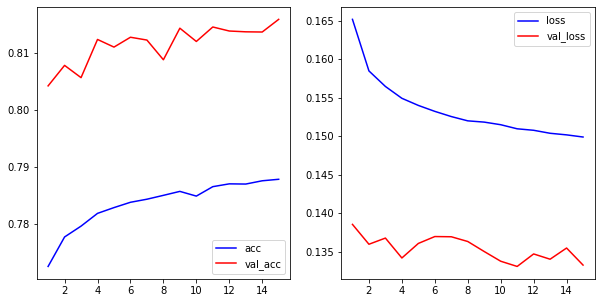

In [ ]:
history_plt(history)

In [ ]:
np.max(history.history['val_accuracy'])

0.8158265352249146

Looking at the plots, we can continue train further to achieve better results.

## 6. Convolutional Neural Network (CNN)

In [ ]:
with tf.device('/cpu:0'):
    model = models.Sequential()

    model.add(layers.Conv1D(16, 3, input_shape=(None, r_xtrain.shape[-1]), activation='relu', kernel_regularizer='l1_l2'))
    model.add(layers.Conv1D(32, 3, activation='relu', kernel_regularizer='l1_l2'))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D())

    model.add(layers.Conv1D(64, 3, activation='relu', kernel_regularizer='l1_l2'))
    model.add(layers.Conv1D(128, 3, activation='relu', kernel_regularizer='l1_l2'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D())

    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(amsgrad=True), loss='mse', metrics='accuracy')
    history = model.fit(x=r_xtrain,
                        y=r_ytrain,
                        epochs=15,
                        validation_data=(r_xtest, r_ytest)
                        )

Epoch 1/15
3554/3554 [==============================] - 25s 7ms/step - loss: 3.5735 - accuracy: 0.7403 - val_loss: 0.1889 - val_accuracy: 0.7979
Epoch 2/15
3554/3554 [==============================] - 24s 7ms/step - loss: 0.2045 - accuracy: 0.7702 - val_loss: 0.1887 - val_accuracy: 0.7979
Epoch 3/15
3554/3554 [==============================] - 28s 8ms/step - loss: 0.2051 - accuracy: 0.7699 - val_loss: 0.1892 - val_accuracy: 0.7979
Epoch 4/15
3554/3554 [==============================] - 24s 7ms/step - loss: 0.2060 - accuracy: 0.7682 - val_loss: 0.1915 - val_accuracy: 0.7979
Epoch 5/15
3554/3554 [==============================] - 23s 6ms/step - loss: 0.2040 - accuracy: 0.7720 - val_loss: 0.1894 - val_accuracy: 0.7979
Epoch 6/15
3554/3554 [==============================] - 28s 8ms/step - loss: 0.2054 - accuracy: 0.7690 - val_loss: 0.1913 - val_accuracy: 0.7979
Epoch 7/15
3554/3554 [==============================] - 24s 7ms/step - loss: 0.2053 - accuracy: 0.7693 - val_loss: 0.1897 - val_ac

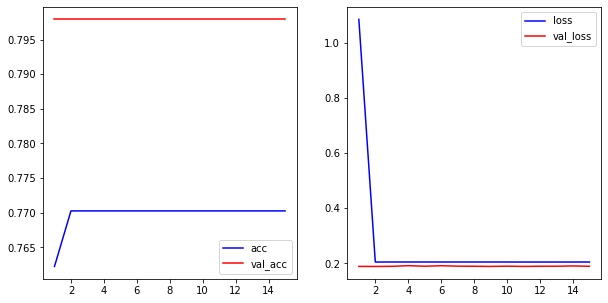

In [ ]:
history_plt(history)

In [ ]:
np.max(history.history['val_accuracy'])

0.7979090213775635

    * XGBClassifier with all parameters: 0.8624
    * XGBClassifier without some dropped parameters: 0.8483
    * LGBMClassifier: 0.8643
    * LGBMClassifier with parameters tuning: 0.8642
    * LGBMClassifier with parameters tuning and feature selection: 0.8587
    * RandomForestClassifier: 0.8607
    * KNeighborsClassifier: 0.8435
    * GaussianNB: 0.8399
    * Ensemble of [RFC, KNC, GNB, LGBM]: 0.8611
    * Reccurent Neural Network: 0.8127
    * Convolutional Neural Network: 0.7979